# architecture-17 ( Basic Classification ) not completed

## What's new:

1- Add


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras import Input
import talib

# Constants
SEQUENCE_LENGTH = 60
FORECAST_HORIZON = 10

In [3]:
# Load dataset
df = pd.read_csv('datasets-17/XAGUSD-H1-rates.csv', sep='\t').dropna()

In [4]:
# Scaling Features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>', '<TICKVOL>']])

In [5]:

# Label trend reversals (example: a simplistic method)
def label_trend_reversals(prices, window=5):
    labels = []
    for i in range(len(prices) - window):
        past = prices[i:i+window//2]
        future = prices[i+window//2:i+window]
        if np.mean(future) > np.mean(past):
            labels.append(1)  # potential buy
        elif np.mean(future) < np.mean(past):
            labels.append(2)  # potential sell
        else:
            labels.append(0)
    labels += [0] * window  # pad
    return labels

df['Label'] = label_trend_reversals(df['<CLOSE>'].values)


In [6]:
# Prepare Sequences
X, y = [], []
for i in range(SEQUENCE_LENGTH, len(scaled_data) - FORECAST_HORIZON):
    X.append(scaled_data[i-SEQUENCE_LENGTH:i])
    y.append(df['Label'].iloc[i:i+FORECAST_HORIZON].values)

X, y = np.array(X), np.array(y)


In [7]:
# Split Dataset
X_train = X[:-1]
y_train = y[:-1]

# Last 60 candles for prediction
X_input = X[-1:]
y_true_future = y[-1]  # for evaluation if desired


In [8]:
from tensorflow.keras.utils import to_categorical

# One-hot encode each timestep's class (3 classes → depth = 3)
y_onehot = np.array([to_categorical(row, num_classes=3) for row in y_train])
# Now shape = (num_samples, 10, 3)


In [9]:
# Build LSTM Classification Model
model = Sequential([
    Input(shape=(SEQUENCE_LENGTH, X.shape[2])),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(FORECAST_HORIZON * 3, activation='softmax'),
    tf.keras.layers.Reshape((FORECAST_HORIZON, 3))
])


I0000 00:00:1753420480.295042   70637 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2361 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5


In [10]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [11]:
# Train the Model
# Fit model
model.fit(X_train, y_onehot, epochs=3, batch_size=64, validation_split=0.1)


Epoch 1/3


I0000 00:00:1753420500.300678   70719 cuda_dnn.cc:529] Loaded cuDNN version 91001


774/774 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.4961 - loss: 0.7601 - val_accuracy: 0.5003 - val_loss: 0.6962
Epoch 2/3
774/774 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.4976 - loss: 0.7012 - val_accuracy: 0.4959 - val_loss: 0.6964
Epoch 3/3
774/774 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5014 - loss: 0.7006 - val_accuracy: 0.4980 - val_loss: 0.6958


In [19]:
# === Load the last 60 rows from a separate CSV file for prediction ===

input_df = pd.read_csv('datasets-17/new-data-for-test/rows-60-from-20240503/rows-60-from-20240503.csv',
                       sep='\t').dropna()

# Ensure the input features match training
input_features = input_df[['<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>', '<TICKVOL>']]
input_scaled = scaler.transform(input_features)

# Reshape for model input
input_sequence = np.expand_dims(input_scaled, axis=0)  # shape: (1, 60, 7)

# Predict class probabilities
pred_probs = model.predict(input_sequence)  # shape: (1, 30) or (1, 10 * 3)

# Reshape and get class labels (assuming 10 x 3 softmax outputs)
forecast_horizon = 10
pred_classes = np.argmax(pred_probs.reshape(forecast_horizon, 3), axis=1)


# pred_classes now contains 10 integers in {0, 1, 2}
print(pred_classes)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
[2 1 1 2 2 2 1 2 1 2]


# plot section

In [22]:
import sys

sys.path.insert(1, '../utils')
import forex_plot_utils
import os

# PARAMETERS
csv1_path = 'datasets-17/new-data-for-test/rows-60-from-20240503/latest-4-for-history.csv'
csv3_path = 'datasets-17/new-data-for-test/rows-60-from-20240503/after.csv'
plot_title = 'Write a suitable title.'
output_plot_path = None  # e.g., 'output.png'

# LOAD DATA FROM CSVS
historical_df = forex_plot_utils.load_csv_with_datetime(csv1_path) if os.path.exists(csv1_path) else None
actual_future_df = forex_plot_utils.load_csv_with_datetime(csv3_path) if os.path.exists(csv3_path) else None

# LOAD DATA FROM PREDICTION
# Combine <DATE> and <TIME> columns into a datetime
input_df['DATETIME'] = pd.to_datetime(actual_future_df['<DATE>'] + ' ' + actual_future_df['<TIME>'])

last_timestamp = input_df['DATETIME'].iloc[-1]
datetime_index = pd.date_range(start=last_timestamp + pd.Timedelta(hours=1), periods=len(prediction[0]), freq='h')

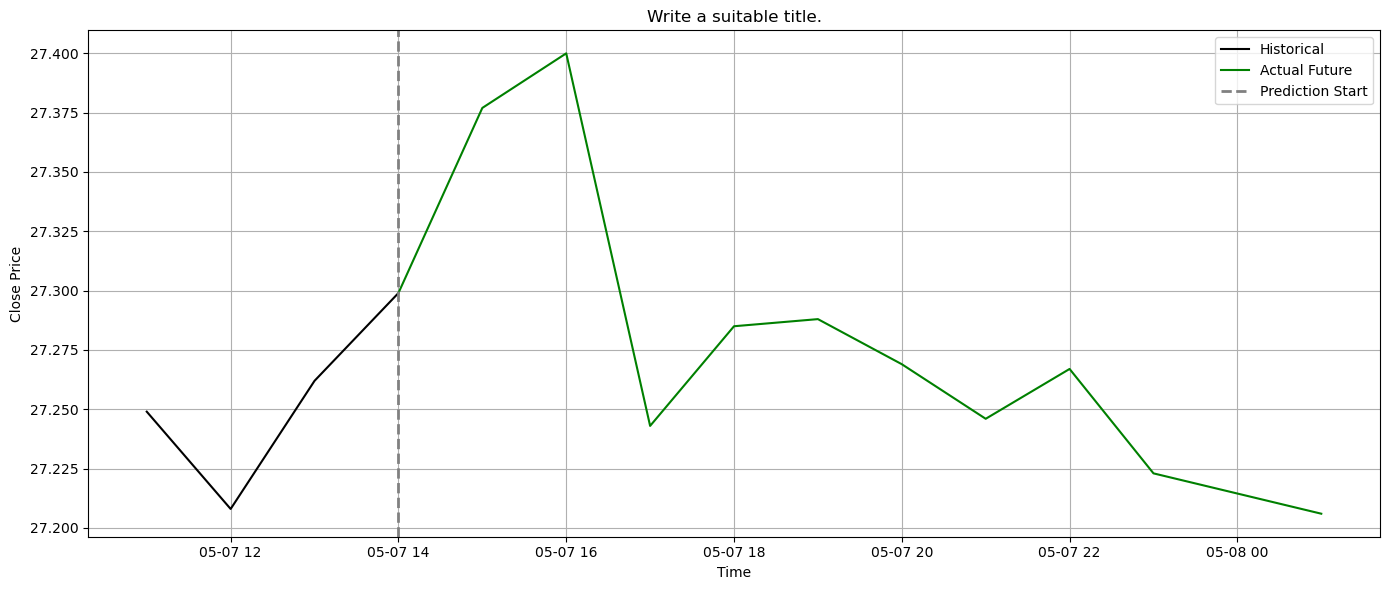

In [23]:
# PLOT
forex_plot_utils.plot_all_series(
    historical_df=historical_df,
    actual_future_df=actual_future_df,
    title=plot_title,
    output_path=output_plot_path
)